`````{note}
This lecture is going to:
* Demonstrate how to load complex time series data with `pandas`
* Introduce interactive plotting with the `plotly` python library
* Review MAE, RMSE, and parity plots for evaluating model fits
* Use `lmfit` to try various non-linear fits, and motivate feature and model choices
* Introduce and demonstrate train/val/test splits
`````

# Intro to Supervised Learning

Let's start with some common tasks in engineering or science that you might come across in your classes, internships, or future jobs:
* insights into complex datasets
* predict properties or behavior of a system
* find patterns in data
* learn how properties are related to outputs or behaviors
* identify where we should add additional data or experiments
* control a process
* ...

All of these are important and things you learn about in your undergrad ChE classes. However, we are limited in how well we can solve these problems by our understanding of the underlying science or our ability to solve/model complex systems. 

Let's start with the most common type of machine learning technique in engineering - supervised learning! 

```{tip}
If you have a physical model (based on mol/mass balances, kinetics, engineering principles, etc that describes your data sufficiently well and accomplishes your goals, stick with it! 
```

## Example dataset: northern hemisphere monthly temperature


To demonstrate important concepts in supervised learning, let's use the northern hemisphere land-surface average temperature dataset prepared by Berkeley Earth non-profit organization. First, let's grab the dataset using wget from http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_complete.txt

`````{note}
wget is a very useful utility for linux/unix to download files off the internet! You can read more about wget by asking for the help documentation with
```
!wget --help
```

`````

In [1]:
!wget http://berkeleyearth.lbl.gov/auto/Regional/TAVG/Text/northern-hemisphere-TAVG-Trend.txt

--2022-09-02 14:00:48--  http://berkeleyearth.lbl.gov/auto/Regional/TAVG/Text/northern-hemisphere-TAVG-Trend.txt
Resolving berkeleyearth.lbl.gov (berkeleyearth.lbl.gov)... 128.3.29.26
Connecting to berkeleyearth.lbl.gov (berkeleyearth.lbl.gov)|128.3.29.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216468 (211K) [text/plain]
Saving to: ‘northern-hemisphere-TAVG-Trend.txt.6’

northern-hemisphere 100%[===================>] 211.39K   445KB/s    in 0.5s    

2022-09-02 14:00:49 (445 KB/s) - ‘northern-hemisphere-TAVG-Trend.txt.6’ saved [216468/216468]



Now, we're going to use pandas to load this dataset into our notebook and look at the data.

In [2]:
import pandas as pd

# Read in the dataset using pandas, and explicitly include the column names
# since pandas has trouble with the header lines in this file
df = pd.read_csv(
    "northern-hemisphere-TAVG-Trend.txt",
    delim_whitespace=True,
    skiprows=70,
    names=[
        "year",
        "month",
        "monthly_anomaly",
        "monthly_anomaly_unc",
        "annual_anomaly",
        "annual_anomaly_unc",
        "fiveyear_anomaly",
        "fiveyear_anomaly_unc",
        "tenyear_anomaly",
        "tenyear_anomaly_unc",
        "twentyyear_anomaly",
        "twentyyear_anomaly_unc",
    ],
).dropna(subset="monthly_anomaly")

# calculate the total temperature from the anomaly column and the average temperatures listed in the header of the CSV file
df["temperature"] = (
    df["monthly_anomaly"]
    + (df["month"] == 1) * -2.06
    + (df["month"] == 2) * -0.04
    + (df["month"] == 3) * 4.57
    + (df["month"] == 4) * 10.35
    + (df["month"] == 5) * 15.74
    + (df["month"] == 6) * 19.67
    + (df["month"] == 7) * 21.32
    + (df["month"] == 8) * 20.21
    + (df["month"] == 9) * 16.63
    + (df["month"] == 10) * 10.99
    + (df["month"] == 11) * 4.52
    + (df["month"] == 12) * -0.38
)

# display the resulting datafrane
df

year  month  monthly_anomaly  monthly_anomaly_unc  annual_anomaly  \
0     1840      1            0.447                1.333             NaN   
1     1840      2           -0.821                1.100             NaN   
2     1840      3           -1.050                1.503          -0.722   
3     1840      4           -0.455                0.622          -0.792   
4     1840      5           -0.002                0.829          -0.794   
...    ...    ...              ...                  ...             ...   
2167  2020      8            1.208                0.147             NaN   
2168  2020      9            1.339                0.161             NaN   
2169  2020     10            1.228                0.147             NaN   
2170  2020     11            1.874                0.123             NaN   
2171  2020     12            1.440                0.244             NaN   

      annual_anomaly_unc  fiveyear_anomaly  fiveyear_anomaly_unc  \
0                    NaN               NaN                   NaN   
1                    NaN               NaN                   NaN   
2                  0.520               NaN                   NaN   
3                  0.483               NaN                   NaN   
4                  0.471               NaN                   NaN   
...                  ...               ...                   ...   
2167                 NaN               NaN                   NaN   
2168                 NaN               NaN                   NaN   
2169                 NaN               NaN                   NaN   
2170                 NaN               NaN                   NaN   
2171                 NaN               NaN                   NaN   

      tenyear_anomaly  tenyear_anomaly_unc  twentyyear_anomaly  \
0                 NaN                  NaN                 NaN   
1                 NaN                  NaN                 NaN   
2                 NaN                  NaN                 NaN   
3                 NaN                  NaN                 NaN   
4                 NaN                  NaN                 NaN   
...               ...                  ...                 ...   
2167              NaN                  NaN                 NaN   
2168              NaN                  NaN                 NaN   
2169              NaN                  NaN                 NaN   
2170              NaN                  NaN                 NaN   
2171              NaN                  NaN                 NaN   

      twentyyear_anomaly_unc  temperature  
0                        NaN       -1.613  
1                        NaN       -0.861  
2                        NaN        3.520  
3                        NaN        9.895  
4                        NaN       15.738  
...                      ...          ...  
2167                     NaN       21.418  
2168                     NaN       17.969  
2169                     NaN       12.218  
2170                     NaN        6.394  
2171                     NaN        1.060  

[2171 rows x 13 columns]

For convenience, we'll start by turning the year and month into a single time

In [3]:
# convert the years and months into a single time
time = df["year"].values + df["month"].values / 12

First, let's plot the data as a function of the year to see what's going on! We'll use plotly to get an interactive graph!

`````{seealso}
More tips and graph types for using plotly! https://plotly.com/python/basic-charts/
`````

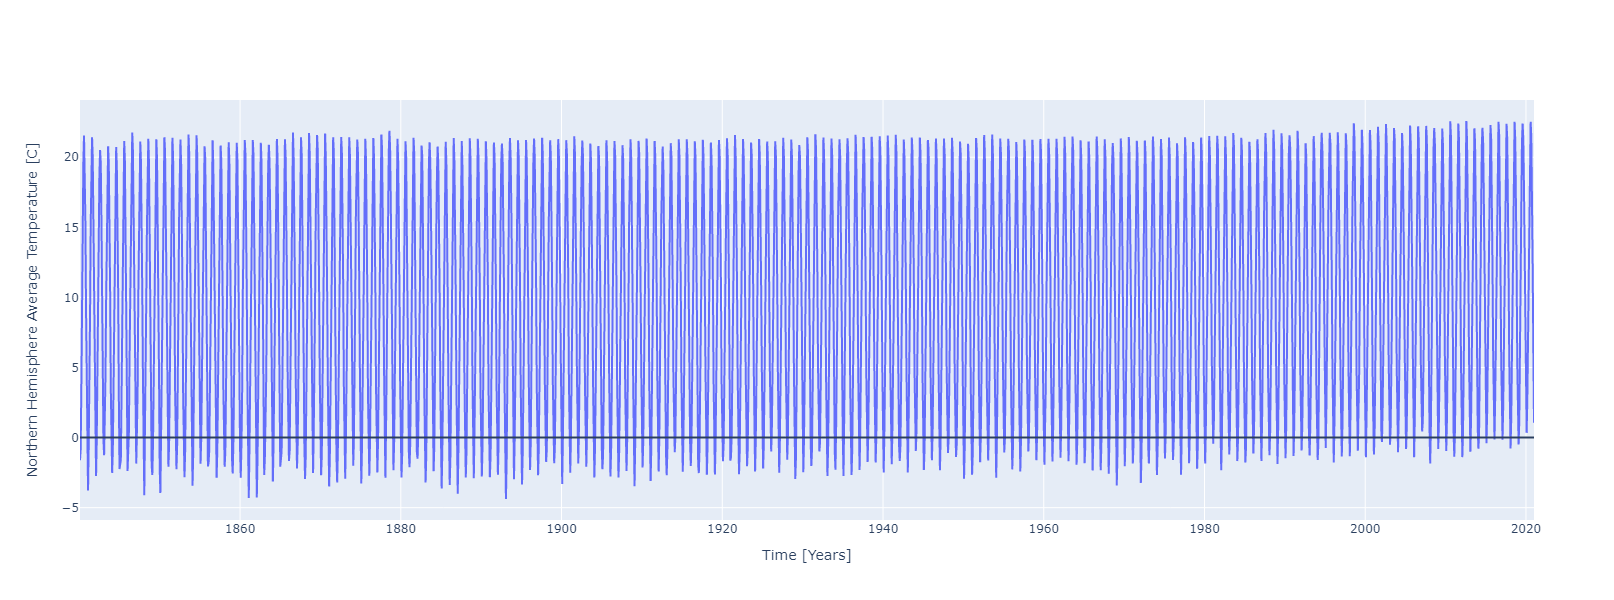

In [4]:
import plotly.graph_objects as go

# Make a plotly graph
fig = go.Figure()
fig.add_scatter(x=time, y=df["temperature"], name="Actual Data")

# Update the x/y axis labels
fig.update_xaxes(title_text="Time [Years]")
fig.update_yaxes(title_text="Northern Hemisphere Average Temperature [C]")

# Add a horizontal line at y=0
fig.add_hline(y=0.0)

# Set the plot size
fig.update_layout(autosize=False, width=1000, height=600)
fig.show()

## Baseline constant model

The very simplest thing we can try is to fit a constant number to the data. Let's try using the lmfit tool that we reviewed last class to fit this function. 
\begin{align*}
\hat{y}(X) = c
\end{align*}
The constant model is a surprisingly helpful baseline - if we can't do better than this with a model, we haven't done anything at all!

`````{note}
* $\hat{y}$ is the outputs (**targets** or **labels**) of the model we want to learn
* $X$ is a **feature matrix**. Each row represents one data point. The columns in $X$ are called features, as they are numbers that together represent each data point.
For this example, X is an Nx1 matrix with a single column - the time we calculated above.

The data that we use to fit the model is called training data, so we'll refer to these as `X_train` and `y_train`.
`````

In [5]:
from lmfit.models import ConstantModel

X_train = time
y_train = df["temperature"].values

# Make a constant model
model = ConstantModel(independent_vars=["x"])
params = model.make_params(c=1)
result = model.fit(y_train, params, x=X_train)

# The constant model just predicts a number, so we do this to make sure the prediction is the same length for all points
y_pred = [result.eval(x=X_train)] * len(y_train)

# Show the result
result

## Evaluating fits (MAE, RMSE, parity plots)

We've completed our initial fit, so we now need to evaluate how well we've done. Let's calculate the mean absolute error and the root mean absolute error of the fit. Remember, the MAE is:
\begin{align*}
\text{Mean Absolute Error (MAE)} &= \frac{1}{N}\sum_i^N |y_i-\hat{y}_i|\\
\text{Root Mean Squared Error (RMSE)} &= \left[\frac{1}{N}\sum_i^N (y_i-\hat{y}_i)^2\right]^{1/2}
\end{align*}
where 
* $y_i$ is the actual (training) data (e.g. monthly anomaly)
* $\hat{y}_i$ is the prediction from the model

To evaluate these, we're going to use the very helpful scikit-learn package (which we'll be using a lot!)

`````{tip}
* The MAE indicates the average residual error and tends to focus on the majority of the points. 
* The RMSE weights larger residuals more and so it more sensitive to outliers or large residuals. The RMSE is always larger than the MAE. 
`````

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_train, y_pred)
rmse = mean_squared_error(y_train, y_pred) ** 0.5
print(f"The MAE for the constant fit is {mae:0.2f} C")
print(f"The RMSE for the constant fit is {rmse:0.2f} C")

The MAE for the constant fit is 7.41 C
The RMSE for the constant fit is 8.33 C


We should also plot the fit to see how it looks visually. In addition to plotting the output, we're also going to use a parity plot.

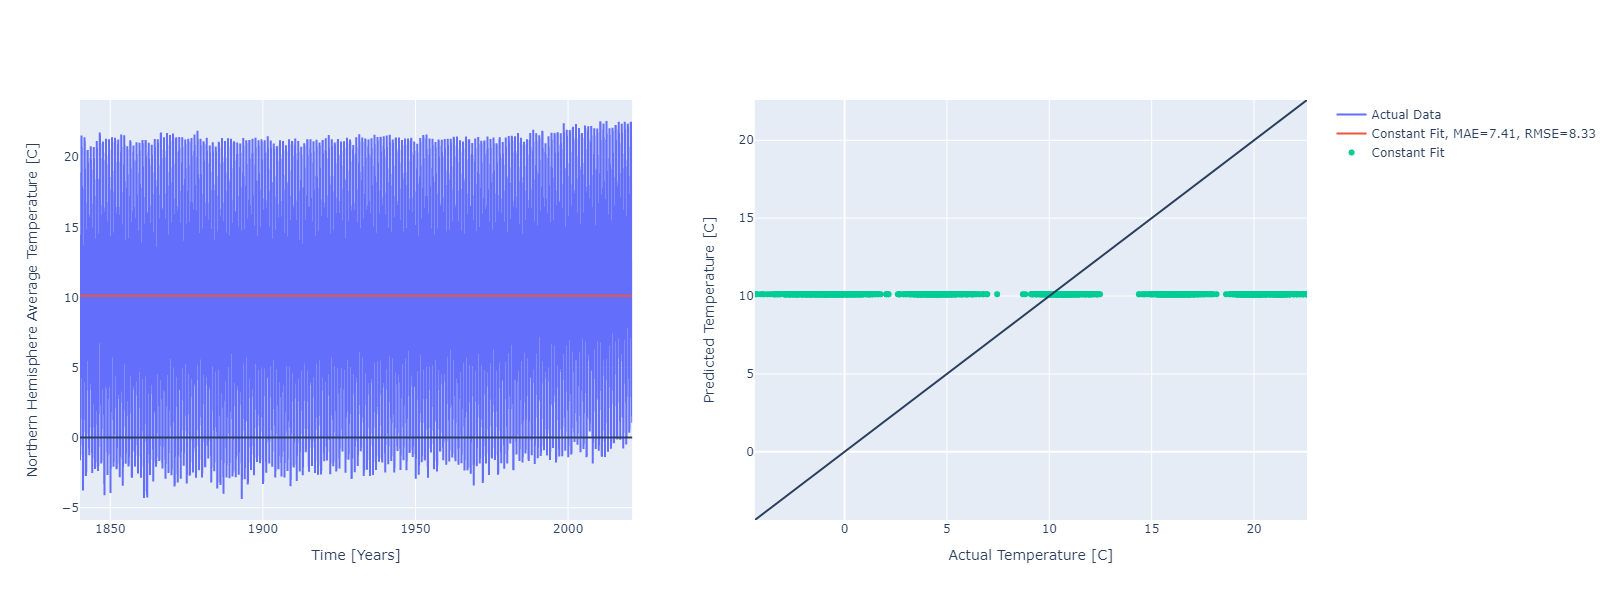

In [7]:
from plotly.subplots import make_subplots

# Make a plotly graph for the temperature data
fig = make_subplots(rows=1, cols=2)
fig.add_scatter(x=X_train, y=y_train, name="Actual Data", row=1, col=1)

# Add a line for the polynomial fit results
fig.add_scatter(
    x=X_train,
    y=y_pred,
    name=f"Constant Fit, MAE={mae:,.2f}, RMSE={rmse:0.02f}",
    row=1,
    col=1,
)

# Update the x/y axis labels
fig.update_xaxes(title_text="Time [Years]", row=1, col=1)
fig.update_yaxes(title_text="Northern Hemisphere Average Temperature [C]", row=1, col=1)

# Add a horizontal line at y=0
fig.add_hline(y=0.0, row=1, col=1)

# Make the parity plot!
fig.add_scatter(
    x=y_train,
    y=y_pred,
    mode="markers",
    name="Constant Fit",
    row=1,
    col=2,
)

# Update the x/y axis labels
fig.update_xaxes(
    title_text="Actual Temperature [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)
fig.update_yaxes(
    title_text="Predicted Temperature [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)

fig.add_shape(
    type="line",
    x0=df["temperature"].min(),
    y0=df["temperature"].min(),
    x1=df["temperature"].max(),
    y1=df["temperature"].max(),
    row=1,
    col=2,
)
# Set the plot size
fig.update_layout(autosize=False, width=1200, height=600)
fig.show()

Note the shape of the parity plot - the model predicts the same number for every point, so this shows up as a horizontal line. This is not a very good fit!


`````{tip}
Parity plots like the one just above (a horizontal line) often indicate that the input data has no relationship to the output data, so the best the model can do is predict the average. This is a surprisingly common issue in machine learning. One common cause is that the data inputs were shuffled or re-ordered compared to the targets (labels), so there really is no correlation in the data.
`````

## Polynomial regression

Let's make this one step more complex but fitting a 4th order polynomial instead. If you remember from 06-262, polynomial models are linear in the fitted parameters since they're of the form $f(x)=c_0+c_1x+c_2x^2+\cdots$, so we expect this minimization to be well-behaved. We could fit this model using linear regression if we wanted.

In [8]:
from lmfit.models import PolynomialModel

X_train = time
y_train = df["temperature"].values

model = PolynomialModel(degree=4, independent_vars=["x"])
params = model.make_params(c0=1, c1=1, c2=1, c3=1, c4=1)
result = model.fit(y_train, params, x=X_train)
y_pred = result.eval(x=X_train)
result

To evaluate the fit, we'll use the same methods (MAE, RMSE, parity plot) as above.

In [9]:
mae = mean_absolute_error(y_train, y_pred)
rmse = mean_squared_error(y_train, y_pred) ** 0.5
print(f"The MAE for the polynomial fit is {mae:0.2f} C")
print(f"The RMSE for the polynomial fit is {rmse:0.2f} C")

The MAE for the polynomial fit is 7.39 C
The RMSE for the polynomial fit is 8.31 C


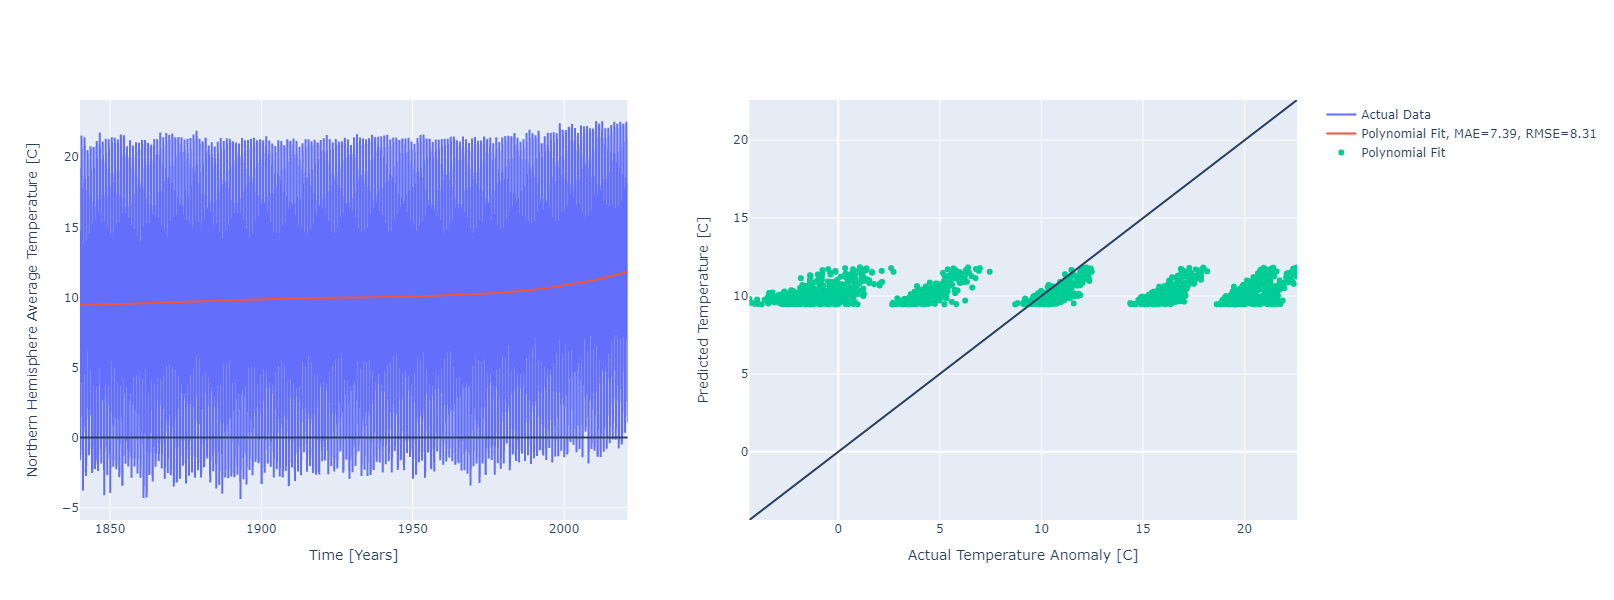

In [10]:
from plotly.subplots import make_subplots

# Make a plotly graph for the temperature data
fig = make_subplots(rows=1, cols=2)
fig.add_scatter(x=time, y=df["temperature"], name="Actual Data", row=1, col=1)

# Add a line for the polynomial fit results
fig.add_scatter(
    x=X_train,
    y=y_pred,
    name=f"Polynomial Fit, MAE={mae:,.2f}, RMSE={rmse:0.02f}",
    row=1,
    col=1,
)

# Update the x/y axis labels
fig.update_xaxes(title_text="Time [Years]", row=1, col=1)
fig.update_yaxes(title_text="Northern Hemisphere Average Temperature [C]", row=1, col=1)

# Add a horizontal line at y=0
fig.add_hline(y=0.0, row=1, col=1)

# Make the parity plot!
fig.add_scatter(
    x=y_train,
    y=y_pred,
    mode="markers",
    name="Polynomial Fit",
    row=1,
    col=2,
)

# Update the x/y axis labels
fig.update_xaxes(
    title_text="Actual Temperature Anomaly [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)
fig.update_yaxes(
    title_text="Predicted Temperature [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)

fig.add_shape(
    type="line",
    x0=df["temperature"].min(),
    y0=df["temperature"].min(),
    x1=df["temperature"].max(),
    y1=df["temperature"].max(),
    row=1,
    col=2,
)
# Set the plot size
fig.update_layout(autosize=False, width=1200, height=600)
fig.show()

We can see a bit of a trend with the years now, which is interesting! The parity plot has a bit more structure. The MAE/RMSE has decreased very slightly.

## Improving the fit by changing the model, or adding features

Using a fourth-order polynomial to predict the monthly anomaly got us a fit with an RMSE of about 0.5 C. We probably want to do better than that. We have two main options:
1. Try a different model (more/less polynomial degrees? completely different type of model? etc.)
2. Add more inputs besides just the time

There's not one right or wrong answer here. Both are feasible, and both will take some creativity on our part. Either we have to have some insight into why another model might be better suited to the dataset, or we have to have some insight into why just the absolute time is not the best feature.

### Adding month as a feature (Month/Year Polynomial)

To start, let's add the month as a feature. Essentially, we're changing our feature matrix $X$ from a single column of the time, to two columns:
* X[:,0] = year
* X[:,1] = month

To keep things simple, let's make it a similar polynomial!

In [11]:
import numpy as np
from lmfit import Model

X_train = np.vstack((df["year"].values, df["month"].values)).T
y_train = df["temperature"].values


def polynomial_year_month(year, month, c0, c1, c2, c3, d1, d2, d3, d4):
    return (
        c0
        + year * c1
        + year**2 * c2
        + year**3 * c3
        + d1 * month
        + d2 * month**2
        + d3 * month**3
        + d4 * month**4
    )


model = Model(
    polynomial_year_month,
    independent_vars=["year", "month"],
    param_names=["c0", "c1", "c2", "c3", "d1", "d2", "d3", "d4"],
)
params = model.make_params(c0=1, c1=1, c2=1, c3=1, d1=1, d2=1, d3=1, d4=1)

result = model.fit(y_train, params, year=X_train[:, 0], month=X_train[:, 1])
y_pred = result.eval(year=X_train[:, 0], month=X_train[:, 1])

In [12]:
mae = mean_absolute_error(y_train, y_pred)
rmse = mean_squared_error(y_train, y_pred) ** 0.5
print(f"The MAE for the constant fit is {mae:0.2f} C")
print(f"The RMSE for the constant fit is {rmse:0.2f} C")

The MAE for the constant fit is 0.37 C
The RMSE for the constant fit is 0.49 C


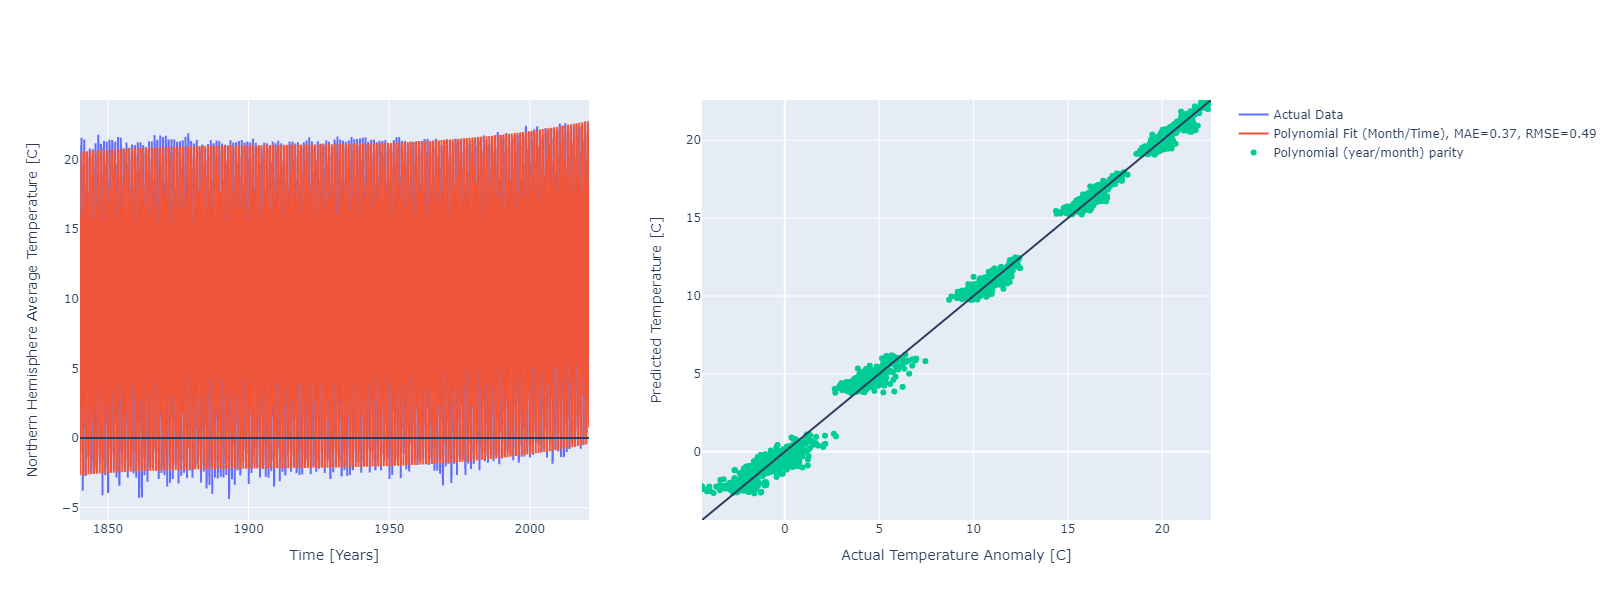

In [13]:
from plotly.subplots import make_subplots

# Make a plotly graph for the temperature data
fig = make_subplots(rows=1, cols=2)
fig.add_scatter(x=time, y=df["temperature"], name="Actual Data", row=1, col=1)

# Add a line for the polynomial fit results
fig.add_scatter(
    x=time,
    y=y_pred,
    name=f"Polynomial Fit (Month/Time), MAE={mae:,.2f}, RMSE={rmse:0.02f}",
    row=1,
    col=1,
)

# Update the x/y axis labels
fig.update_xaxes(title_text="Time [Years]", row=1, col=1)
fig.update_yaxes(title_text="Northern Hemisphere Average Temperature [C]", row=1, col=1)

# Add a horizontal line at y=0
fig.add_hline(y=0.0, row=1, col=1)

# Make the parity plot!
fig.add_scatter(
    x=df["temperature"],
    y=y_pred,
    mode="markers",
    name="Polynomial (year/month) parity",
    row=1,
    col=2,
)

# Update the x/y axis labels
fig.update_xaxes(
    title_text="Actual Temperature Anomaly [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)
fig.update_yaxes(
    title_text="Predicted Temperature [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)

fig.add_shape(
    type="line",
    x0=df["temperature"].min(),
    y0=df["temperature"].min(),
    x1=df["temperature"].max(),
    y1=df["temperature"].max(),
    row=1,
    col=2,
)
# Set the plot size
fig.update_layout(autosize=False, width=1200, height=600)
fig.show()

Now we're getting somewhere! The MAE/RMSE have fallen to ~0.37/0.49 C respectively. The parity plot also looks much nicer now, with results scattering around the parity line.

### Change the model (Polynomial+Sin)

It's not a huge surprise that there is some periodicity in the model. A reasonable guess for a more reasonable function could include a periodic (sin) component. Let's try:
\begin{align*}
f(t) = c_0+c_1t+c_2t^2+c_3t^3+c_4t^4+A\sin (\omega t+\phi)
\end{align*}
Note that we aren't explicitly using the month info here.

In [14]:
import numpy as np
from lmfit.models import PolynomialModel, SineModel

X_train = time
y_train = df["temperature"].values

poly_model = PolynomialModel(degree=4, independent_vars=["x"])
sine_model = SineModel(independent_vars=["x"])
model = sine_model + poly_model
params = model.make_params(
    c0=1, c1=1, c2=1, c3=1, c4=1, frequency=2 * np.pi, amplitude=10, shift=0 * np.pi
)
result = model.fit(y_train, params, x=X_train)
y_pred = result.eval(x=X_train)

In [15]:
mae = mean_absolute_error(df["temperature"], y_pred)
rmse = mean_squared_error(df["temperature"], y_pred) ** 0.5
print(f"The MAE for the polynomial+sin fit is {mae:0.2f} C")
print(f"The RMSE for the polynomial+sin fit is {rmse:0.2f} C")

The MAE for the polynomial+sin fit is 0.63 C
The RMSE for the polynomial+sin fit is 0.79 C


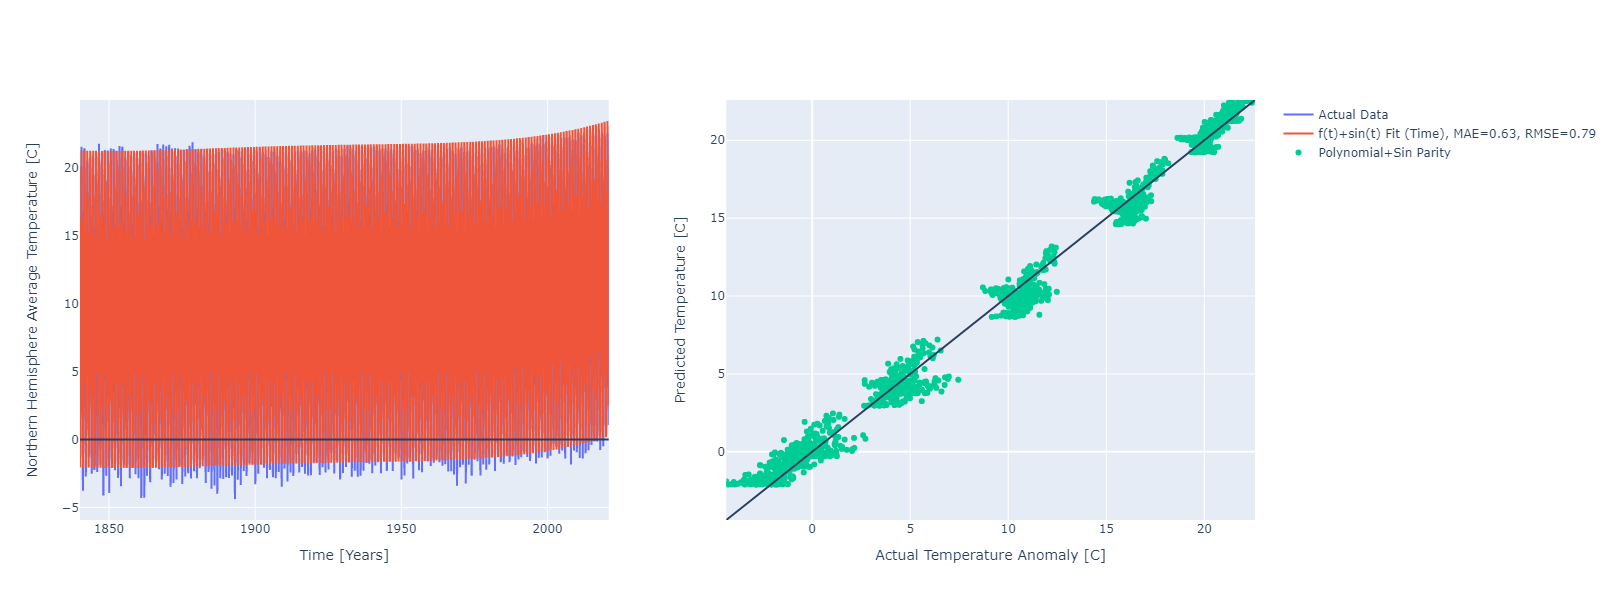

In [16]:
from plotly.subplots import make_subplots

# Make a plotly graph for the temperature data
fig = make_subplots(rows=1, cols=2)
fig.add_scatter(x=time, y=df["temperature"], name="Actual Data", row=1, col=1)

# Add a line for the polynomial fit results
fig.add_scatter(
    x=X_train,
    y=y_pred,
    name=f"f(t)+sin(t) Fit (Time), MAE={mae:,.2f}, RMSE={rmse:0.02f}",
    row=1,
    col=1,
)

# Update the x/y axis labels
fig.update_xaxes(title_text="Time [Years]", row=1, col=1)
fig.update_yaxes(title_text="Northern Hemisphere Average Temperature [C]", row=1, col=1)

# Add a horizontal line at y=0
fig.add_hline(y=0.0, row=1, col=1)

# Make the parity plot!
fig.add_scatter(
    x=y_train,
    y=y_pred,
    mode="markers",
    name="Polynomial+Sin Parity",
    row=1,
    col=2,
)

# Update the x/y axis labels
fig.update_xaxes(
    title_text="Actual Temperature Anomaly [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)
fig.update_yaxes(
    title_text="Predicted Temperature [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)

fig.add_shape(
    type="line",
    x0=df["temperature"].min(),
    y0=df["temperature"].min(),
    x1=df["temperature"].max(),
    y1=df["temperature"].max(),
    row=1,
    col=2,
)

# Set the plot size
fig.update_layout(autosize=False, width=1200, height=600)
fig.show()

This fit is also pretty good, but not quite as good as our double polynomial from above.


`````{warning}
This fit is quite sensitive to the initial conditions! Try other sets of parameter guesses and see how the answers change!
`````

## Pitfalls with fitting models using all of the available data


So far, we've evaluated modeling techniques by fitting the model using all of the available data. Based on the metrics we calculated, it seems like we should be able to predict the temperature for any month/year within about 0.5 degrees C.

However, there are a few major issues:
* We have no idea how the model will work for predicting things it hasn't seen before
* We have no idea if or the model will extrapolate
* We can perfectly fit most data by just throwing more polynomial features and fitted parameters at the problem

### Model extrapolation 

As a demonstration, let's check how our last model from above works for predicting temperatures in the future, or before the first available data (1840).

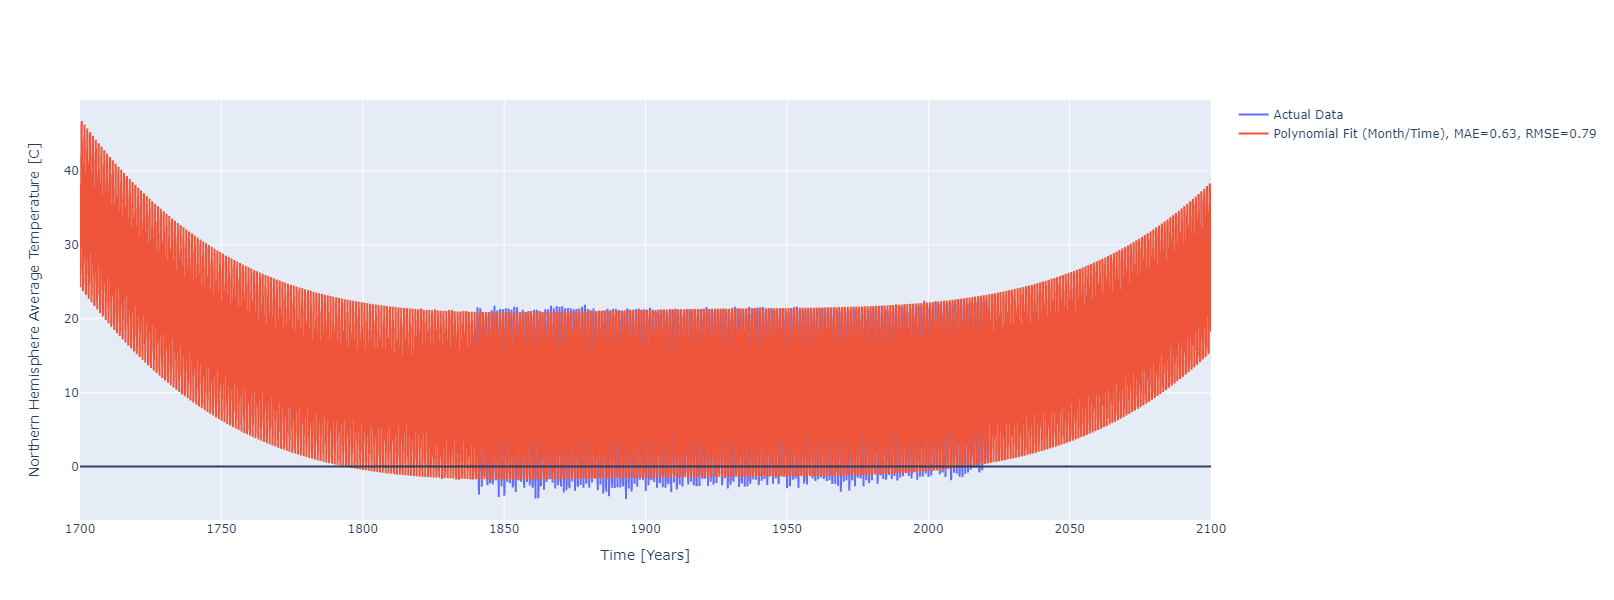

In [17]:
import numpy as np
from lmfit.models import PolynomialModel, SineModel

# Make a plotly graph for the temperature data
fig = go.Figure()
fig.add_scatter(x=time, y=df["temperature"], name="Actual Data")

# Add a line for the polynomial fit results
fig.add_scatter(
    x=np.linspace(1700, 2100, 12 * 400),
    y=result.eval(x=np.linspace(1700, 2100, 12 * 400)),
    name=f"Polynomial Fit (Month/Time), MAE={mae:,.2f}, RMSE={rmse:0.02f}",
)

# Update the x/y axis labels
fig.update_xaxes(title_text="Time [Years]")
fig.update_yaxes(title_text="Northern Hemisphere Average Temperature [C]")

# Add a horizontal line at y=0
fig.add_hline(y=0.0)

# Set the plot size
fig.update_layout(autosize=False, width=1200, height=600)
fig.show()

Notice that although the model fits reasonably well within the range of the dataset, if we ask it to make predictions in the future, or for data points before the start of the data, the predictions are far too high. The temperature in 1700 was definitely not 20 degrees C higher than the 1900s, and global warming predictions is expected to be significantly than the 15C predicted here. 

We want models that can predict things that we haven't seen before, so we need to change our way of evaluating the models.

## Train/validation/test splits

We want our models to be predictive! That is, they should work for data they haven't seen before, and be useful in practice. To accomplish this, we use train/validation/test data splits to see how our fitted models work in synthetic scenarios.


`````{note}
* **Train:** The data that we actually show our models during the fitting process
* **Validation:** Data that we predict on with our trained models and use to decide which model to use, or how to adjust various parameters in the fitting procedure
* **Test:** Data that we set aside and look at as infrequently as possible. This should represent some data that the model has never seen before and is indicative of the real world task
`````

### Random train/val/test split

The most approach in supervised learning is a random train/validation/test split, in ratios of something like 80%/10%/10%. That is, we fit a bunch of models to the same 80% of the data. We pick the best one by asking which works best on the validation 10%. And then we try that model on the test 10% to see if it works in practice!


Let's try this with our sample dataset. To do so we'll use more scikit learn tools.https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

`````{seealso}
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
`````

In [18]:
from sklearn.model_selection import train_test_split

# Make one big 2d array that holds all of the data we might want to use
X = np.vstack((time, df["year"], df["month"])).T

# split the data into train/val/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, df["temperature"], test_size=0.1, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=1 / 9, random_state=42
)

# Check the train/val/test shapes
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_val.shape)
print(y_val.shape)

(1736, 3)
(1736,)
(218, 3)
(218,)
(217, 3)
(217,)


Now that we have our train/validation/test split, let's see how this works in practice! 

First, we fit the model using the training data using our competing models and predict on the validation set to pick the best model.

In [19]:
import numpy as np
from lmfit.models import PolynomialModel, SineModel

poly_model = PolynomialModel(degree=4, independent_vars=["x"])
sine_model = SineModel(independent_vars=["x"])
model = sine_model + poly_model
params = model.make_params(
    c0=1, c1=1, c2=1, c3=1, c4=1, frequency=2 * np.pi, amplitude=10, shift=-2 * np.pi
)
result = model.fit(y_train, params, x=X_train[:, 0])
y_val_pred = polysin_result.eval(x=X_val[:, 0])

mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred) ** 0.5
print(f"The MAE for the polynomial+sin model fit is {mae:0.2f} C")
print(f"The RMSE for the  polynomial+sin model fit is {rmse:0.2f} C")

The MAE for the polynomial+sin model fit is 0.52 C
The RMSE for the  polynomial+sin model fit is 0.66 C


In [20]:
import numpy as np
from lmfit import Model


def polynomial_year_month(year, month, c0, c1, c2, c3, d1, d2, d3, d4):
    return (
        c0
        + year * c1
        + year**2 * c2
        + year**3 * c3
        + d1 * month
        + d2 * month**2
        + d3 * month**3
        + d4 * month**4
    )


gmodel = Model(
    polynomial_year_month,
    independent_vars=["year", "month"],
    param_names=["c0", "c1", "c2", "c3", "d1", "d2", "d3", "d4"],
)
params = gmodel.make_params(c0=1, c1=1, c2=1, c3=1, d1=1, d2=1, d3=1, d4=1)

result = gmodel.fit(y_train, params, year=X_train[:, 1], month=X_train[:, 2])
y_val_pred = monthyear_result.eval(year=X_val[:, 1], month=X_val[:, 2])

mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred) ** 0.5
print(f"The MAE for the month/year polynomial model fit is {mae:0.2f} C")
print(f"The RMSE for the  month/year polynomial model fit is {rmse:0.2f} C")

The MAE for the month/year polynomial model fit is 0.39 C
The RMSE for the  month/year polynomial model fit is 0.52 C


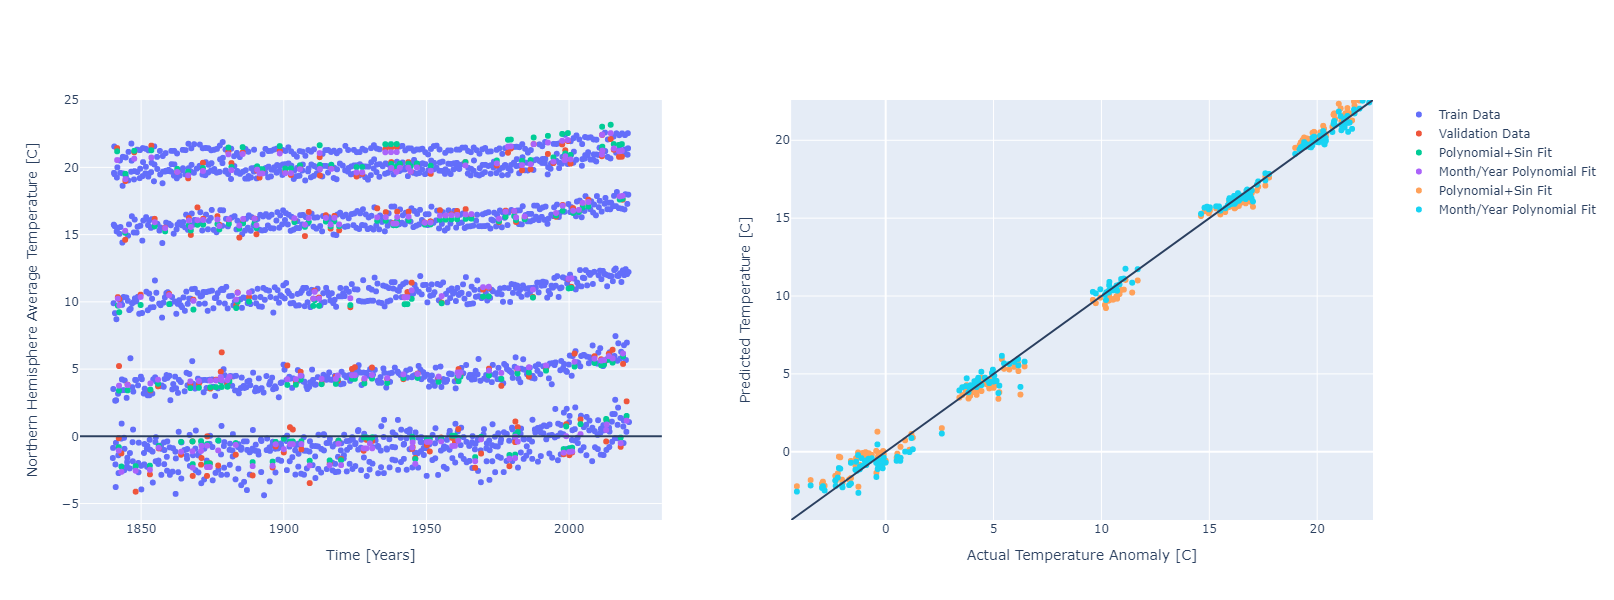

In [21]:
# Make a plotly graph for the temperature data
fig = make_subplots(rows=1, cols=2)
fig.add_scatter(
    x=X_train[:, 0], y=y_train, name="Train Data", row=1, col=1, mode="markers"
)
fig.add_scatter(
    x=X_val[:, 0], y=y_val, name="Validation Data", row=1, col=1, mode="markers"
)

# Add a line for the polynomial fit results
fig.add_scatter(
    x=X_val[:, 0],
    y=result.eval(x=X_val[:, 0]),
    name=f"Polynomial+Sin Fit",
    mode="markers",
    row=1,
    col=1,
)

fig.add_scatter(
    x=X_val[:, 0],
    y=monthyear_result.eval(year=X_val[:, 1], month=X_val[:, 2]),
    name=f"Month/Year Polynomial Fit",
    mode="markers",
    row=1,
    col=1,
)

# Update the x/y axis labels
fig.update_xaxes(title_text="Time [Years]", row=1, col=1)
fig.update_yaxes(title_text="Northern Hemisphere Average Temperature [C]", row=1, col=1)

# Add a horizontal line at y=0
fig.add_hline(y=0.0, row=1, col=1)

# Make the parity plot!
fig.add_scatter(
    x=y_val,
    y=polysin_result.eval(x=X_val[:, 0]),
    mode="markers",
    name="Polynomial+Sin Fit",
    row=1,
    col=2,
)

# Make the parity plot!
fig.add_scatter(
    x=y_val,
    y=monthyear_result.eval(year=X_val[:, 1], month=X_val[:, 2]),
    mode="markers",
    name="Month/Year Polynomial Fit",
    row=1,
    col=2,
)

# Update the x/y axis labels
fig.update_xaxes(
    title_text="Actual Temperature Anomaly [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)
fig.update_yaxes(
    title_text="Predicted Temperature [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)

fig.add_shape(
    type="line",
    x0=df["temperature"].min(),
    y0=df["temperature"].min(),
    x1=df["temperature"].max(),
    y1=df["temperature"].max(),
    row=1,
    col=2,
)
# Set the plot size
fig.update_layout(autosize=False, width=1200, height=600)
fig.show()

Surprisingly, the polynomial/sin fit works even better than with all of the training data! This probably means that we could have done better with other initial conditions in the optimization above.

## Time series train/val/test splits

We are getting pretty close to a standard machine learning pipeline. However, we need to think a bit about the task we've indicated with the random train/val/test split. We chose the validation and test randomly from the entire time series, so the task is basically whether we can fill in missing time points. 

A more useful model would be one that could predict the average temperature. Let's try repeating the train/val/test split, but do it without shuffling. This will represent a task:
* Models are fit on data from 1840-1985
* The models are asked to predict the validation data from 1985-2003, and the best model is chosen based on its ability to predict 20 years in to the future
* The best model is fit on the train and validation data and used to predict the test data from 2003-2022

In [22]:
from sklearn.model_selection import train_test_split

# Make one big 2d array that holds all of the data we might want to use
X = np.vstack((time, df["year"], df["month"])).T

# split the data into train/val/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, df["temperature"], test_size=0.1, random_state=42, shuffle=False
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=1 / 9, random_state=42, shuffle=False
)

# Check the train/val/test shapes
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_val.shape)
print(y_val.shape)

(1736, 3)
(1736,)
(218, 3)
(218,)
(217, 3)
(217,)


In [23]:
import numpy as np
from lmfit.models import PolynomialModel, SineModel

poly_model = PolynomialModel(degree=4, independent_vars=["x"])
sine_model = SineModel(independent_vars=["x"])
model = sine_model + poly_model
params = model.make_params(
    c0=1, c1=1, c2=1, c3=1, c4=1, frequency=2 * np.pi, amplitude=10, shift=-2 * np.pi
)
polysin_result = model.fit(y_train, params, x=X_train[:, 0])
y_val_pred = polysin_result.eval(x=X_val[:, 0])

mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred) ** 0.5
print(f"The MAE for the polynomial+sin model fit is {mae:0.2f} C")
print(f"The RMSE for the  polynomial+sin model fit is {rmse:0.2f} C")

The MAE for the polynomial+sin model fit is 8.40 C
The RMSE for the  polynomial+sin model fit is 9.36 C


In [36]:
import numpy as np
from lmfit import Model


def polynomial_year_month(year, month, c0, c1, c2, c3, d1, d2, d3, d4):
    return (
        c0
        + year * c1
        + year**2 * c2
        + year**3 * c3
        + d1 * month
        + d2 * month**2
        + d3 * month**3
        + d4 * month**4
    )


gmodel = Model(
    polynomial_year_month,
    independent_vars=["year", "month"],
    param_names=["c0", "c1", "c2", "c3", "d1", "d2", "d3", "d4"],
)
params = gmodel.make_params(c0=1, c1=1, c2=1, c3=1, d1=1, d2=1, d3=1, d4=1)

result = gmodel.fit(y_train, params, year=X_train[:, 1], month=X_train[:, 2])
y_val_pred = monthyear_result.eval(year=X_val[:, 1], month=X_val[:, 2])

mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred) ** 0.5
print(f"The MAE for the month/year polynomial model fit is {mae:0.2f} C")
print(f"The RMSE for the  month/year polynomial model fit is {rmse:0.2f} C")

The MAE for the month/year polynomial model fit is 0.38 C
The RMSE for the  month/year polynomial model fit is 0.51 C


The MAE for the second model is far better. Clearly the first has trouble extrapolating to the future, or possibly the initial parameter guesses don't work very well for this new data!

The last thing to do is train this model on train/val data and predict on the test to see how well it actually does for the most recent 20 years or so!

In [37]:
result = gmodel.fit(
    np.hstack((y_train, y_val)),
    params,
    year=np.vstack((X_train, X_val))[:, 1],
    month=np.vstack((X_train, X_val))[:, 2],
)
y_test_pred = monthyear_result.eval(year=X_test[:, 1], month=X_test[:, 2])

mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
print(f"The MAE for the month/year polynomial model fit is {mae:0.2f} C")
print(f"The RMSE for the  month/year polynomial model fit is {rmse:0.2f} C")

The MAE for the month/year polynomial model fit is 0.37 C
The RMSE for the  month/year polynomial model fit is 0.52 C


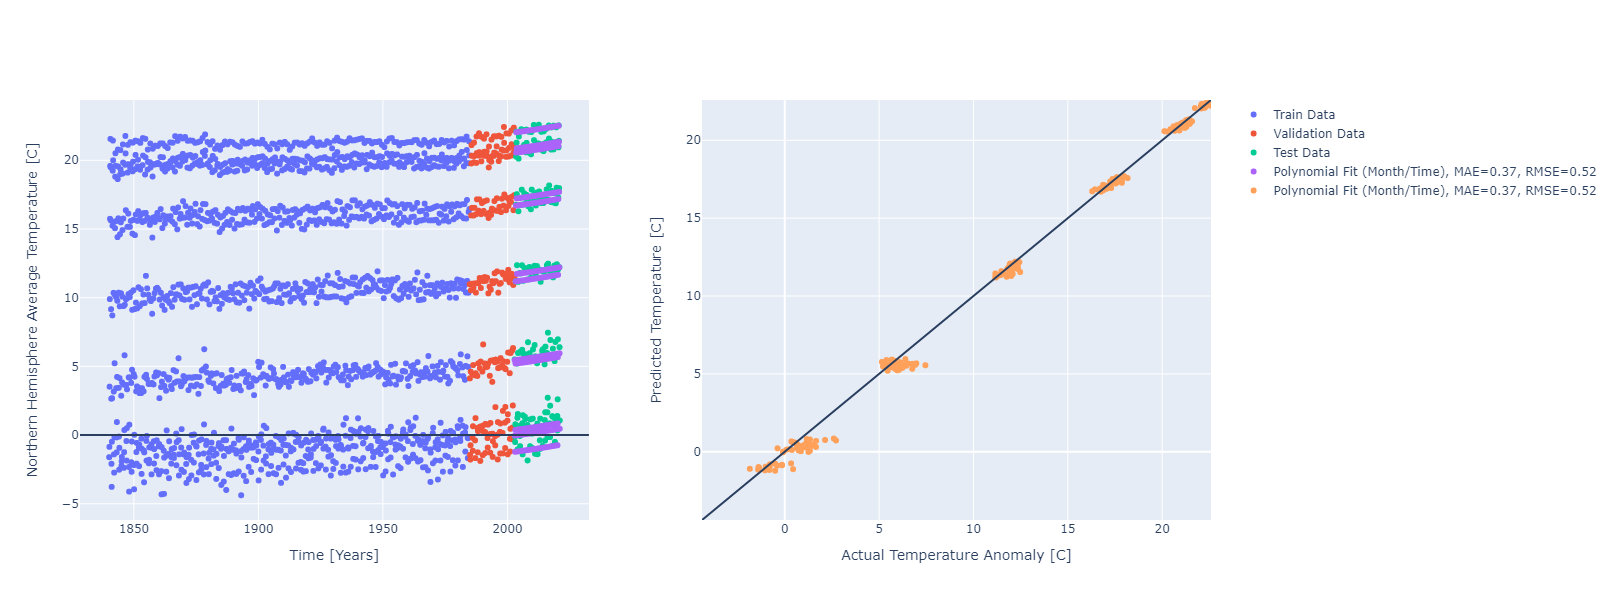

In [43]:
# Make a plotly graph for the temperature data
fig = make_subplots(rows=1, cols=2)
fig.add_scatter(
    x=X_train[:, 0], y=y_train, name="Train Data", row=1, col=1, mode="markers"
)
fig.add_scatter(
    x=X_val[:, 0], y=y_val, name="Validation Data", row=1, col=1, mode="markers"
)
fig.add_scatter(
    x=X_test[:, 0], y=y_test, name="Test Data", row=1, col=1, mode="markers"
)

# Add a line for the polynomial fit results
fig.add_scatter(
    x=X_test[:, 0],
    y=result.eval(year=X_test[:, 1],month=X_test[:, 2]),
    name=f"Polynomial Fit (Month/Time), MAE={mae:,.2f}, RMSE={rmse:0.02f}",
    mode="markers",
    row=1,
    col=1,
)


# Update the x/y axis labels
fig.update_xaxes(title_text="Time [Years]", row=1, col=1)
fig.update_yaxes(title_text="Northern Hemisphere Average Temperature [C]", row=1, col=1)

# Add a horizontal line at y=0
fig.add_hline(y=0.0, row=1, col=1)

# Make the parity plot!
fig.add_scatter(
    x=y_test,
    y=result.eval(year=X_test[:, 1],month=X_test[:, 2]),
    mode="markers",
    name=f"Polynomial Fit (Month/Time), MAE={mae:,.2f}, RMSE={rmse:0.02f}",
    row=1,
    col=2,
)

# Update the x/y axis labels
fig.update_xaxes(
    title_text="Actual Temperature Anomaly [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)
fig.update_yaxes(
    title_text="Predicted Temperature [C]",
    range=[df["temperature"].min(), df["temperature"].max()],
    row=1,
    col=2,
)

fig.add_shape(
    type="line",
    x0=df["temperature"].min(),
    y0=df["temperature"].min(),
    x1=df["temperature"].max(),
    y1=df["temperature"].max(),
    row=1,
    col=2,
)
# Set the plot size
fig.update_layout(autosize=False, width=1200, height=600)
fig.show()

We now have a pretty good idea of what level of accuracy we can expect moving forward. The parity plot looks reasonable, and the RMSE is ~0.52 C for the test set. Assuming that the system does not have major forces acting on it (like significant climate change action), we can probably use this model to forecast the next 10 years. Hopefully this isn't a good assumption!